<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_learn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import requests
from io import StringIO
filename = '512_posts_23_topics.csv'
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')

In [13]:
import nltk
from nltk.tokenize import word_tokenize
!pip install -U pymorphy3
import pymorphy3
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя-')
morph = pymorphy3.MorphAnalyzer(lang='ru')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 54.7 MB/s eta 0:00:00


In [14]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

def process_text(text):
    check_hash = False
    processed_parts = []
    for w in nltk.word_tokenize(text):
      if len(w) == 1:
        continue
      w_tag = morph.parse(w.strip())[0].tag
      if set(w.lower()).issubset(alphabet):
        if w.isalpha() and w.lower():
          if w.isupper() and len(w) <= 3:
              processed_parts.append(w)
          else:
              res = morph.parse(w.lower())[0].normal_form
              if res not in stop_words:
                  processed_parts.append(res)
    result = ' '.join(processed_parts)
    return str(result)

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'].lower())


In [15]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # посчитать точность на тестовой сотне

In [16]:
unique_topics = train_docs['topic'].unique()
len(unique_topics)

25

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
# Создаем векторizer
vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)

# Преобразуем текст в матрицу
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])

# Получаем названия признаков (слов)
words = vectorizer.get_feature_names_out()  # Используем get_feature_names_out()

doc_test_matrix = vectorizer.transform(test_docs['normalized'])
topic_labels = ['Тема {}'.format(i) for i in range(1, 28)]

lda = LatentDirichletAllocation(n_components=27, n_jobs=-1, max_iter=500,
                                learning_method='batch', evaluate_every=5,
                                verbose=1, random_state=42)
lda.fit(doc_train_matrix)



joblib.dump(lda, 'model.pkl')  # Сохранение модели
lda = joblib.load('model.pkl')  # Загрузка модели

topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 524869.7316
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 416713.3516
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 359784.6479
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 318563.4734
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 304600.7485
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9,Тема 10,...,Тема 18,Тема 19,Тема 20,Тема 21,Тема 22,Тема 23,Тема 24,Тема 25,Тема 26,Тема 27
аварийный,0.005029,0.000478,0.000318,0.000436,0.000301,0.000452,0.000361,0.000310,0.00038,0.000466,...,0.0003,0.000351,0.000388,0.000434,0.000242,0.000413,0.00021,0.000345,0.000409,0.000418
август,0.000207,0.000478,0.004547,0.000436,0.007091,0.000452,0.000361,0.002677,0.00038,0.000466,...,0.0003,0.000351,0.000388,0.000434,0.000242,0.002142,0.00021,0.000345,0.000409,0.005195
автор,0.000207,0.000478,0.000318,0.000436,0.000301,0.000452,0.000361,0.000310,0.00038,0.000466,...,0.0003,0.000351,0.000388,0.000434,0.001956,0.000413,0.00021,0.002255,0.000409,0.000418
авторский,0.000207,0.000478,0.000318,0.000436,0.000301,0.000452,0.000361,0.000310,0.00038,0.000466,...,0.0003,0.000351,0.000388,0.000434,0.000242,0.000413,0.00021,0.000345,0.002101,0.000418
агентство,0.000207,0.001745,0.003019,0.000436,0.000301,0.000452,0.000361,0.000310,0.00038,0.000466,...,0.0003,0.004172,0.000388,0.000434,0.000242,0.000413,0.00021,0.000345,0.000409,0.000418


In [18]:
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9,Тема 10,...,Тема 18,Тема 19,Тема 20,Тема 21,Тема 22,Тема 23,Тема 24,Тема 25,Тема 26,Тема 27
0,школа,ремесло,развитие,зерно,река,вепсский,ссылка,финский,отряд,снег,...,сказка,выпуск,сутки,чай,калевала,октябрь,пример,музей,наступать,апрель
1,семья,молодёжь,карел,калитка,море,издать,название,сво,загадка,подворье,...,константин,видео,район,самовар,руно,общественный,язык,национальныймузейкарелия,запись,акция
2,заявка,союз,форум,валентина,завтра,дарья,обсуждение,заседание,знаток,ленинградский,...,вдохновение,калитка,коронавирус,инто,руна,концерт,опубликовать,выставка,ткацкий,проводиться
3,класс,курган,север,серия,войско,швецов,снимать,рабочий,навык,видно,...,март,информационный,ситуация,инх,художник,внимание,стена,билет,съезд,пудожский
4,желать,кадриль,государственный,присоединяться,август,кодим,хештэг,сладкий,попробовать,ехать,...,музыкальный,исполнение,госпитализировать,конрад,театр,зарисовка,неделя,рубль,услышать,сайт
5,фотография,приглашать,номинация,фестиваль,коренной,губа,выкладывать,маргарита,сказитель,шелтозеро,...,духовный,кухня,завтра,беломорский,эпос,галина,ответ,национальный,основа,тикканена
6,детский,результат,нко,пожаловать,костюм,небольшой,бывать,ход,смысл,мужской,...,международный,ансамбль,инфекция,наступать,годкарельскихрун,максимальный,месяц,занятие,александр,интерактивный
7,деревня,пряжинский,интересный,здравствуйте,школьник,фестиваль,присылать,совет,группа,зарисовка,...,загадка,век,пневмония,символ,сотрудник,суоярви,перевод,временной,новость,строительство
8,тысяча,изделие,экспозиция,победитель,момент,хоровой,вепс,благодарить,совершенно,животное,...,тепло,казачий,пациент,трансляция,карельскиесказитель,озеро,хештег,май,музыкальный,лидер
9,сцена,старинный,постоянный,делиться,установить,сортавальский,сообщение,причина,колледж,географический,...,сезон,документ,зарегистрировать,пословица,известный,декабрь,написать,игрушка,алексей,хореография


In [19]:
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

<ipython-input-20-e2e8dccc8187>:3: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, 'Обучение: Тематики')

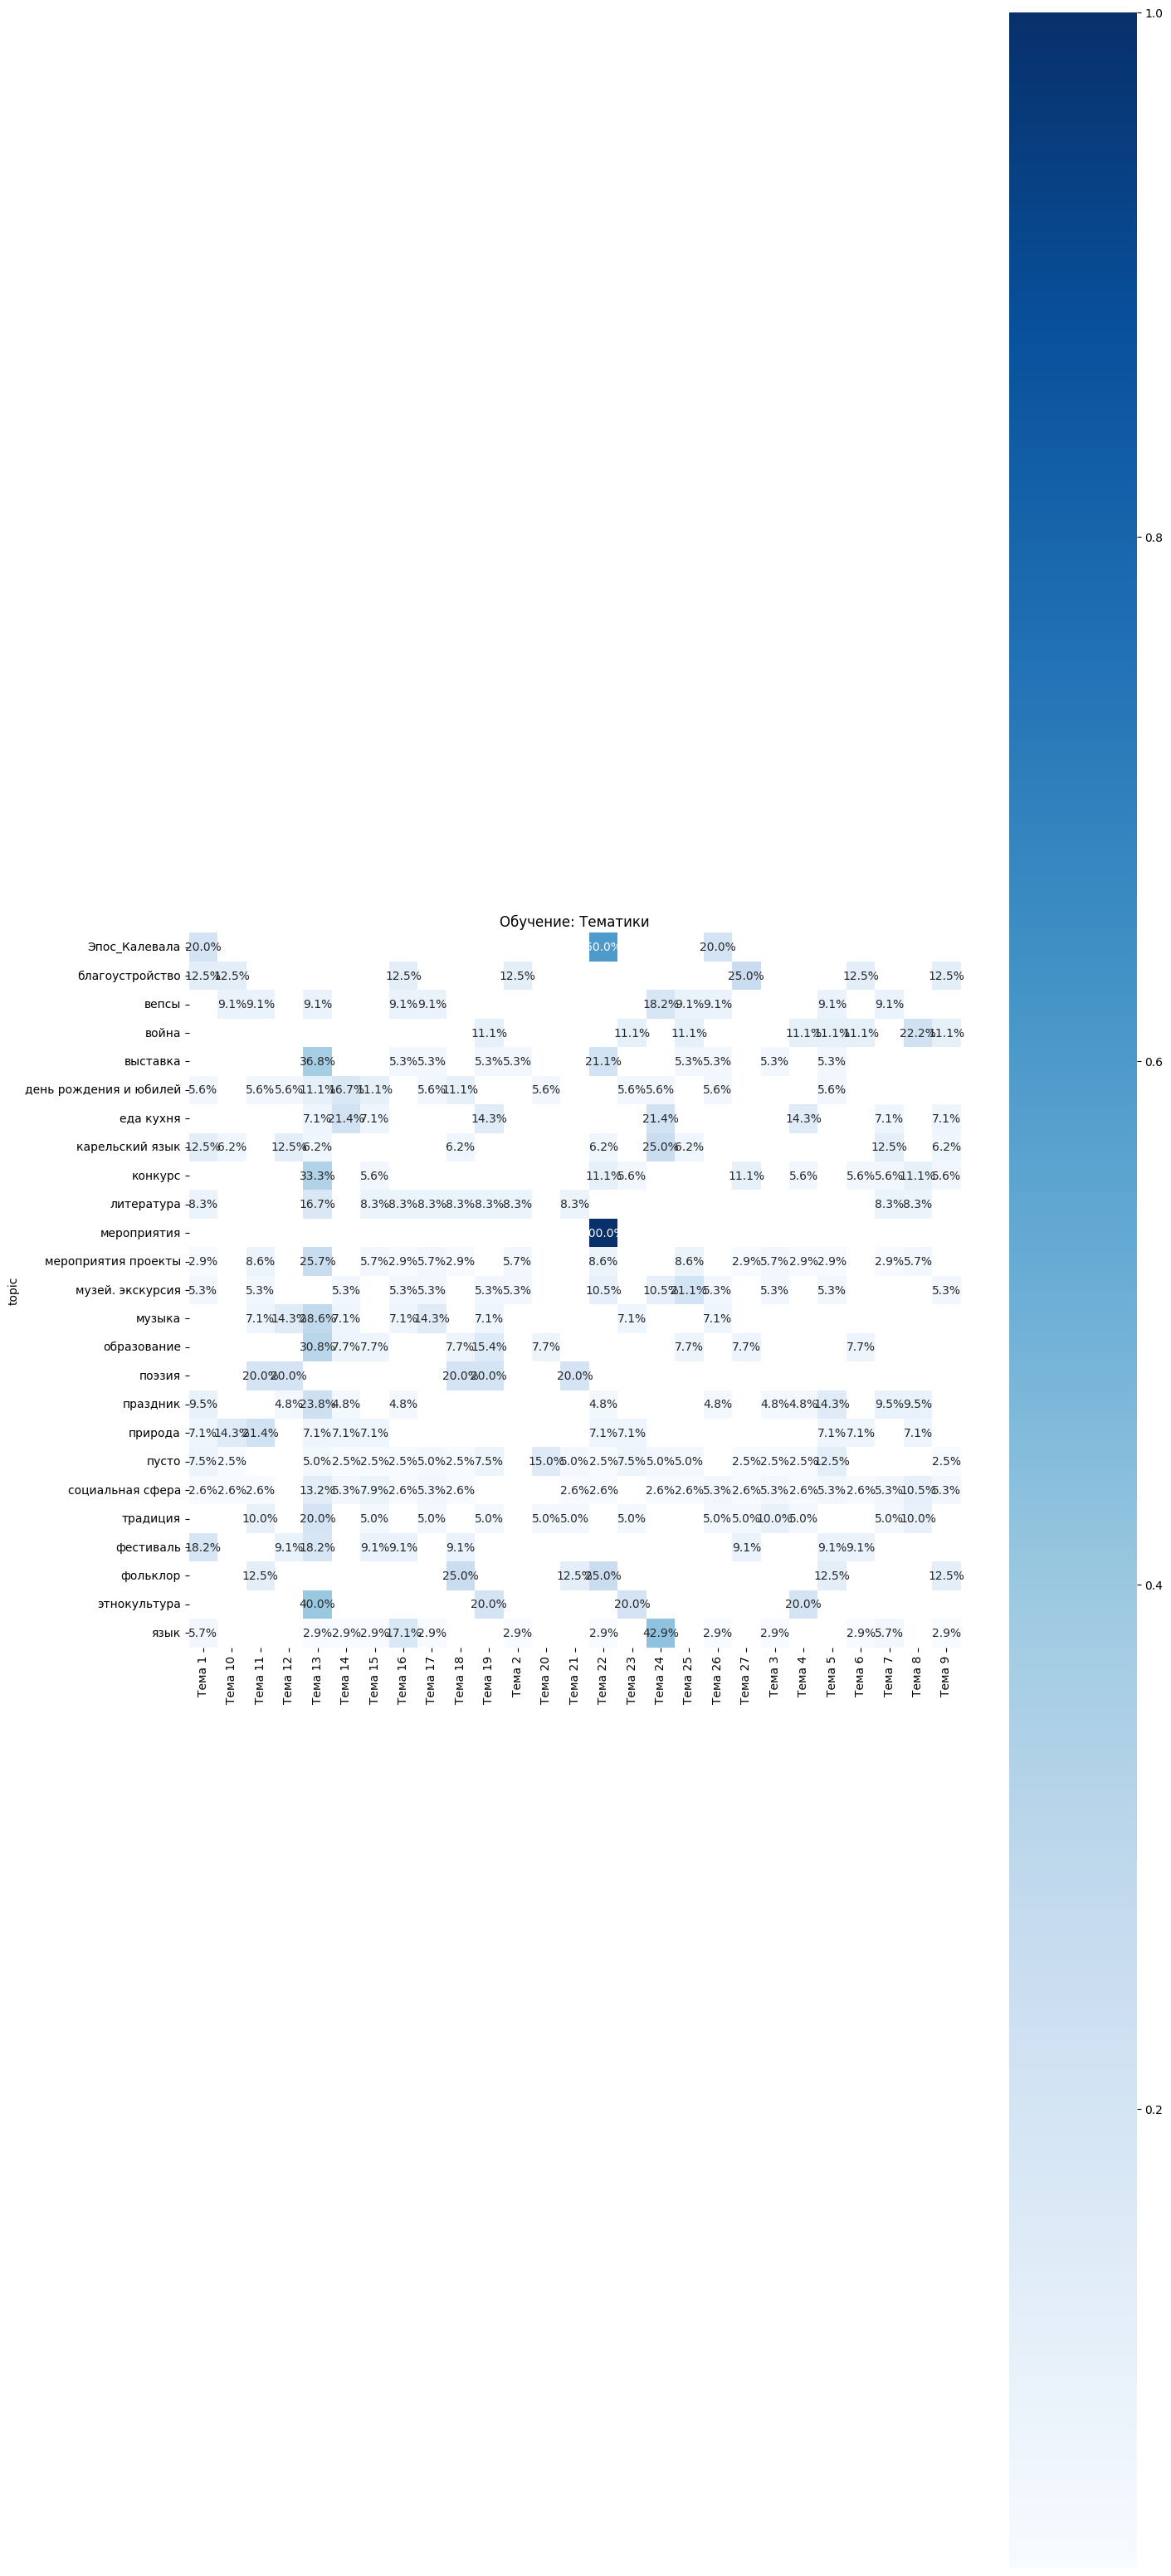

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(15, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Обучение: Тематики')


In [21]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9,Тема 10,...,Тема 18,Тема 19,Тема 20,Тема 21,Тема 22,Тема 23,Тема 24,Тема 25,Тема 26,Тема 27
topic,,,,,,,,,,,,,,,,,,,,,
мероприятия проекты,0.010376,0.010376,0.010376,0.578178,0.010376,0.010376,0.010376,0.010376,0.010376,0.010376,...,0.010376,0.010376,0.010376,0.010376,0.010376,0.010376,0.162432,0.010376,0.010376,0.010376
мероприятия проекты,0.029268,0.005513,0.066082,0.005513,0.055696,0.005513,0.005513,0.005513,0.005513,0.005513,...,0.005513,0.027747,0.027129,0.005513,0.005513,0.056677,0.005513,0.005513,0.005513,0.005513
пусто,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,...,0.007026,0.550558,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026,0.007026
образование,0.219833,0.006022,0.006022,0.006022,0.006022,0.006022,0.006022,0.006022,0.006022,0.006022,...,0.006022,0.006022,0.006022,0.006022,0.052789,0.006022,0.006022,0.006022,0.006022,0.006022
вепсы,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,...,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767,0.009767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
традиция,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,...,0.006980,0.818526,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980,0.006980
образование,0.012886,0.005103,0.005103,0.005103,0.015088,0.005103,0.005103,0.005103,0.005103,0.005103,...,0.005103,0.005103,0.005103,0.005103,0.216214,0.005103,0.005103,0.039813,0.005103,0.005103
мероприятия проекты,0.011568,0.699224,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,...,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568,0.011568


In [22]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

<ipython-input-22-827e74a28c9f>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


**Визуализация в виде тепловой карты (heatmap) для анализа распределения тем в наборе данных: тестовый (test_eval)**

<ipython-input-23-9b315acb5e67>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = test_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, 'Данные обучения: Тематические задания')

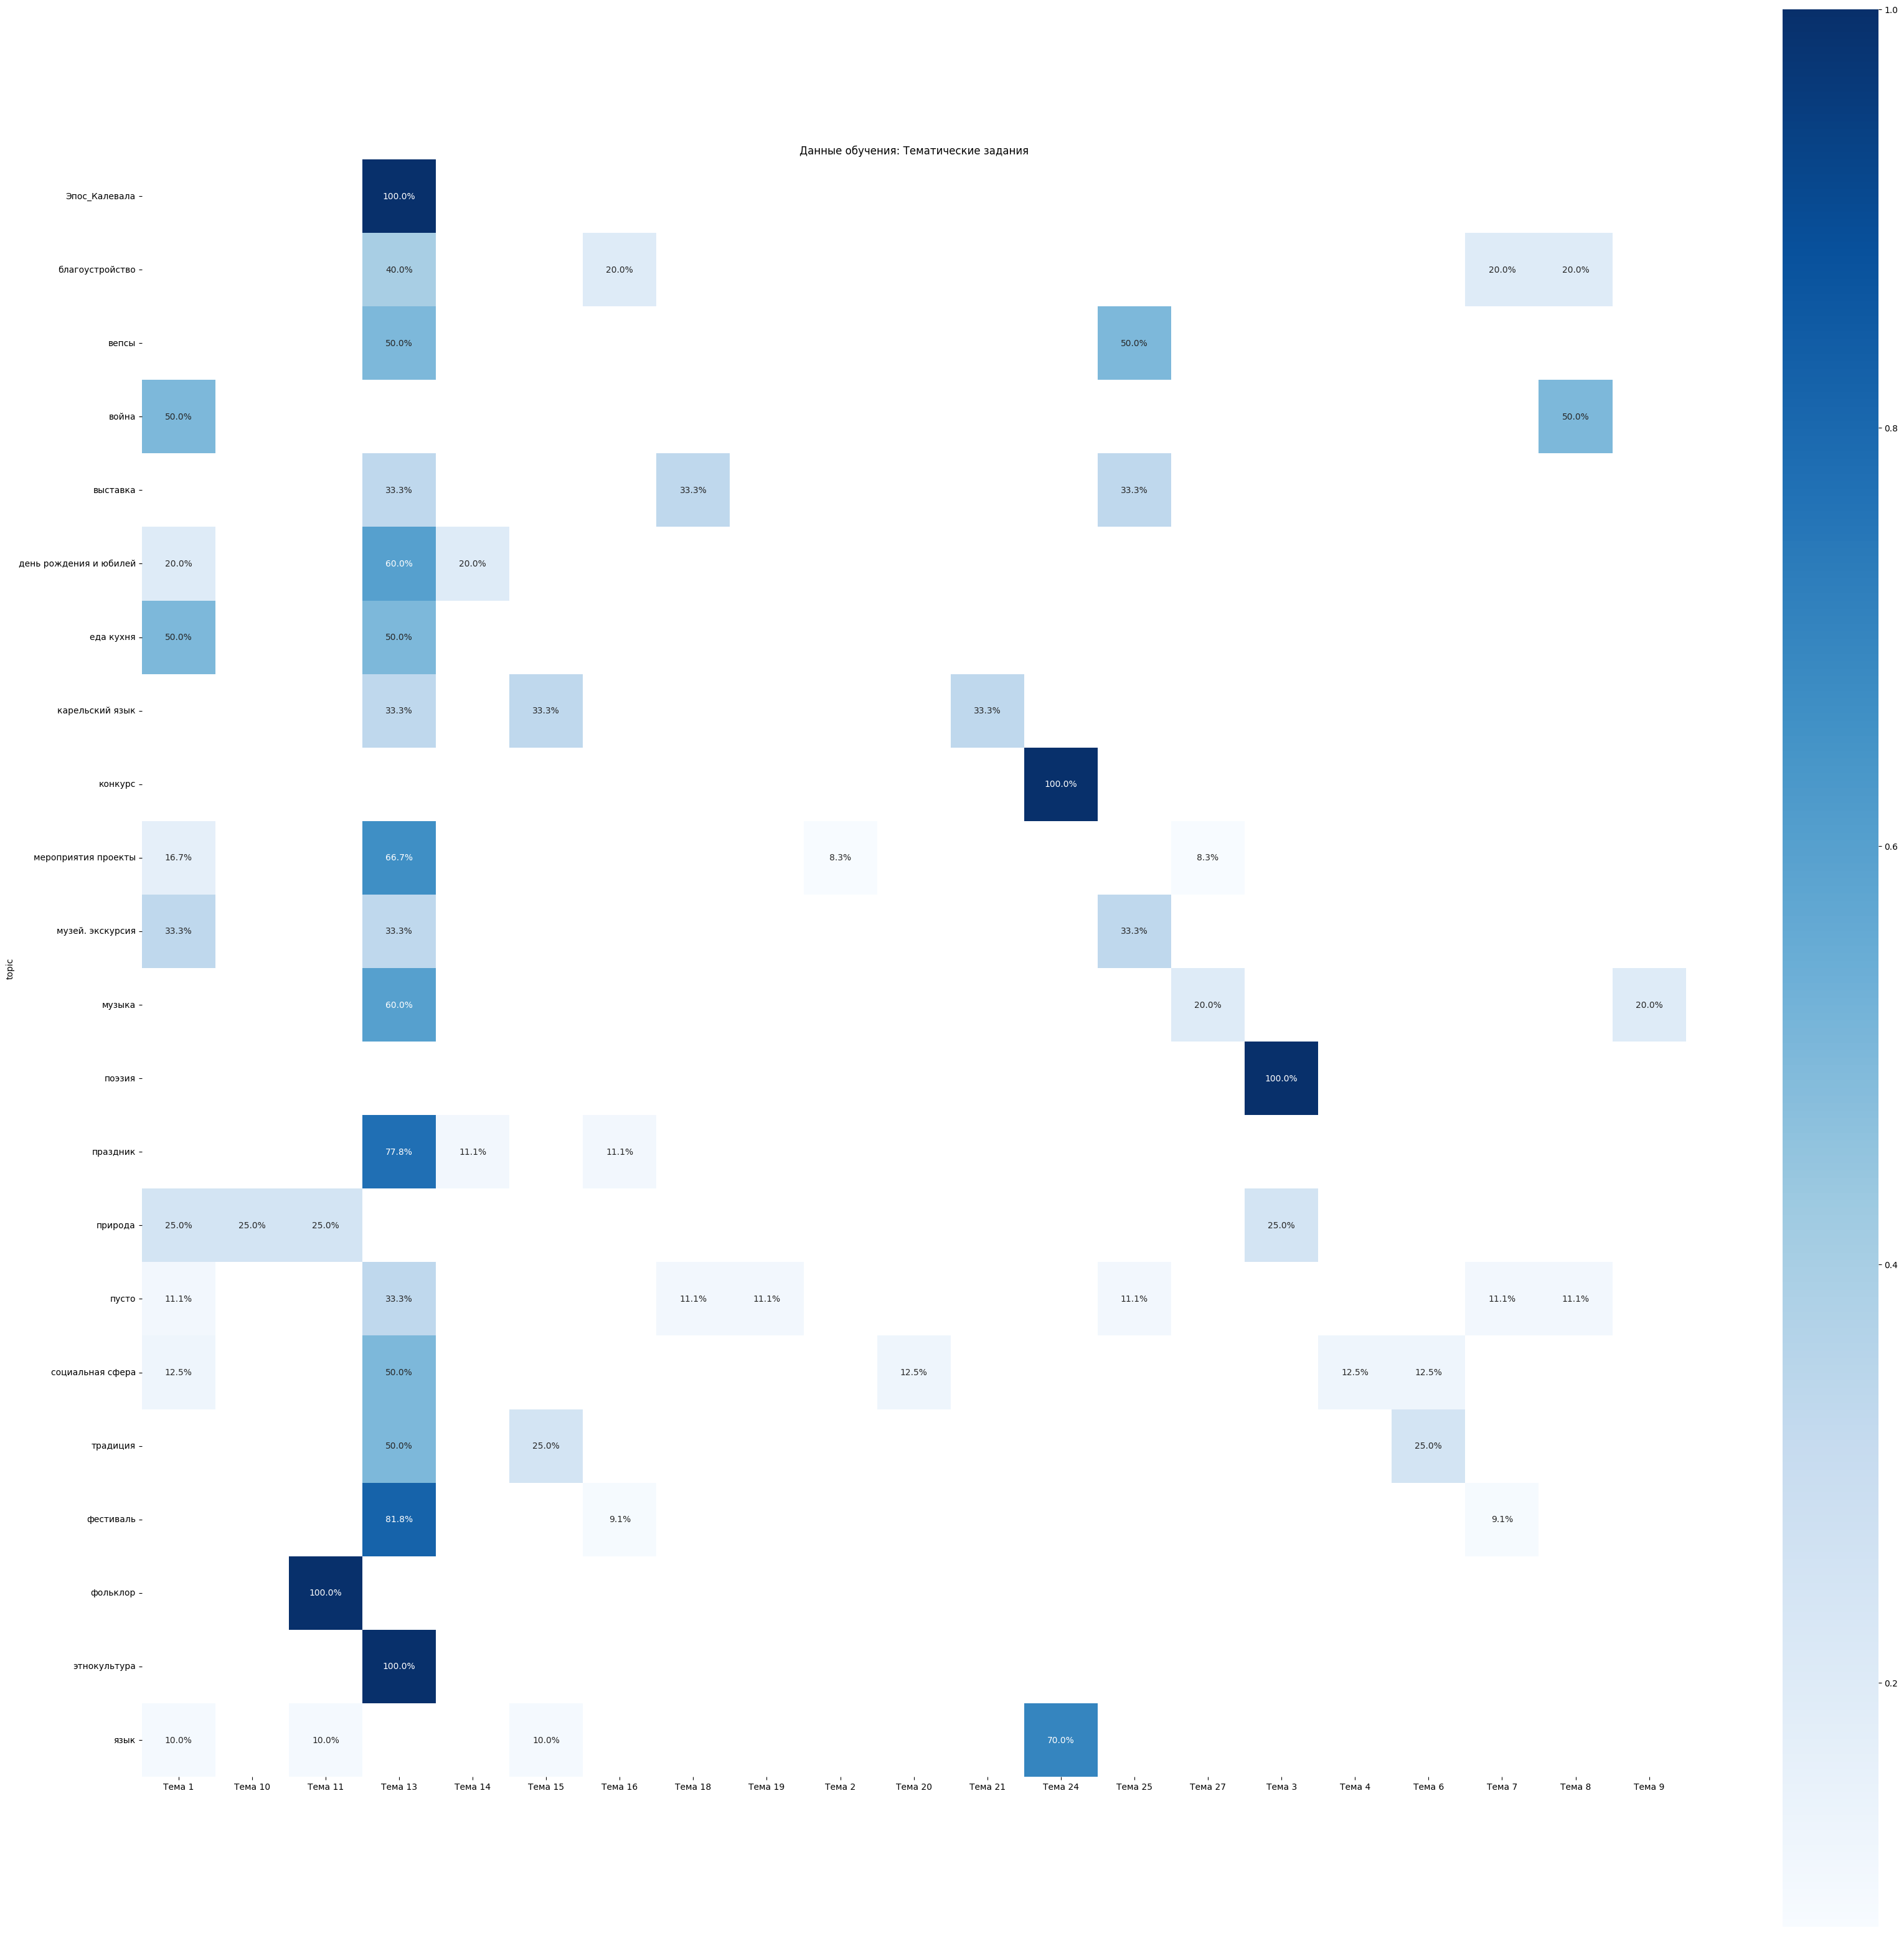

In [23]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(40, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Данные обучения: Тематические задания')

In [24]:
test_assignments = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['text'] = test_docs.text.values
test_assignments.head(5)

<ipython-input-24-c37182911221>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='topic').idxmax(


,topic,predicted,text
0,Эпос_Калевала,Тема 13,Бери друзей - смотри музей! Сегодня приглашае...
1,благоустройство,Тема 8,️🎥Предлагаем вам посмотреть интересный ролик с...
2,благоустройство,Тема 16,💥 Сегодня руководитель Карельской республиканс...
3,благоустройство,Тема 13,"""ОСЕНЬ Въ ГОРОДѣ О.""🍁🍂 МАСТЕР-КЛАСС ПО СКАНДИН..."
4,благоустройство,Тема 7,"Какое растение вепсы называют ""GADAN LUZIK"" бу..."


In [25]:
test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)
                   .reset_index(-1, drop=True)
                   .to_frame('predicted')
                   .reset_index())

test_assignments['text'] = test_docs.text.values

war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments
war_assignments.to_csv("war.csv")

<ipython-input-25-2aea02cd00df>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)


In [26]:
test_assignments.to_csv("res.csv")